In [13]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import os
import cv2

from PSMNet.PSMNet import PSMNet
from utils.read_data import *

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [14]:
# left_path = '/home/lab1/datasets/DFC2019_track2_grayscale_8bit/Track2-RGB-1/JAX_017_012_001_LEFT_RGB.tif'
# right_path = '/home/lab1/datasets/DFC2019_track2_grayscale_8bit/Track2-RGB-1/JAX_017_012_001_RIGHT_RGB.tif'
left_path = './img/JAX_004_009_007_LEFT_RGB.tif'
right_path = './img/JAX_004_009_007_RIGHT_RGB.tif'

In [15]:
img_l = Image.open(left_path)
img_l = img_l.resize((1024,1024))
img_l = np.array(img_l)
img_r = Image.open(right_path)
img_r = img_r.resize((1024,1024))
img_r = np.array(img_r)

tensor_l = img_norm(img_l)
tensor_r = img_norm(img_r)

tensor_l = tensor_l.unsqueeze(0).to(device)
tensor_r = tensor_r.unsqueeze(0).to(device)

print(tensor_l.shape)

torch.Size([1, 3, 1024, 1024])


In [16]:
net = PSMNet()
net.load_state_dict(torch.load('./training_checkpoints/2000steps_PSMNet_DFC2019.pth'), strict=True)
net.eval()
net = net.to(device)


disp max:  1.4323257 disp min:  0.5000278


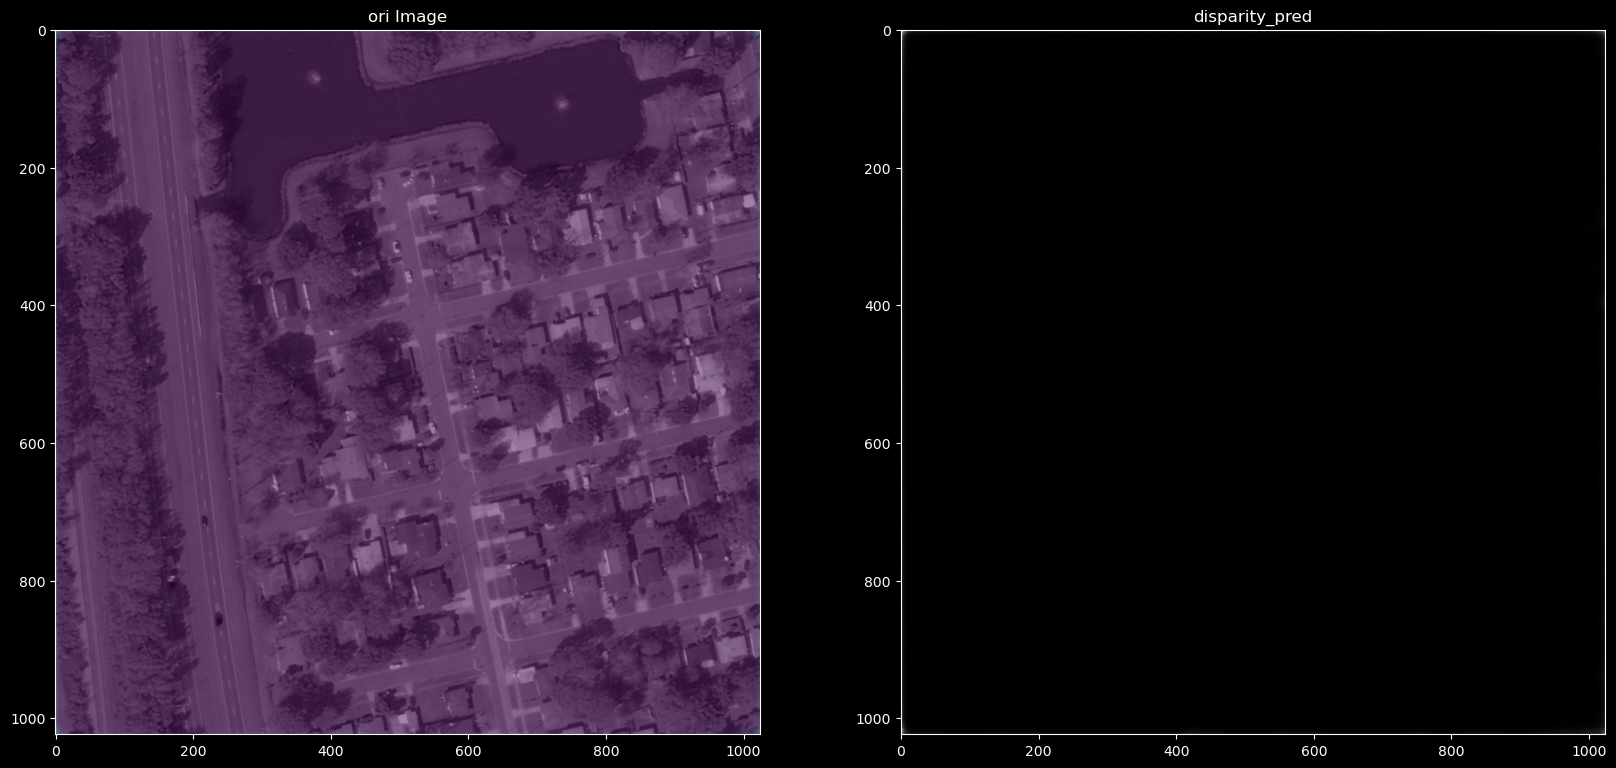

In [17]:
with torch.no_grad():
    disp = net(tensor_l, tensor_r, 0, 64)
    disp = disp.squeeze().cpu().numpy()
    print("disp max: ", disp.max(), "disp min: ", disp.min())
#visualize
f, axis = plt.subplots(1, 2, figsize = (20,60))
axis[0].imshow(img_l)
axis[0].imshow(disp, alpha=0.5)
axis[0].set_title('ori Image')
axis[1].imshow(disp, cmap='gray')
axis[1].set_title('disparity_pred')
plt.show()

In [18]:
os.makedirs("demo_output", exist_ok=True)
cv2.imwrite('./demo_output/img.tif', disp)

True